In [1]:
%load_ext autoreload
%autoreload 2    

In [2]:
import csv
from torchvision import datasets, models, transforms
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

from augmentation import *
from train import train, train_transfer
from config.transfer_config import *

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
IMG_SIZE = 300

In [5]:
transforms_auto = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE), antialias=True),
                                      transforms.AutoAugment(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # For the Imagenet Transfer learning
                              
                                     ])
transforms_auto_test = transforms.Compose([transforms.ToTensor(),
                                           transforms.Resize((IMG_SIZE,IMG_SIZE), antialias=True),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # For the Imagenet Transfer learning
                              
                                          ])

In [6]:
trainset = datasets.ImageFolder('/dtu/datasets1/02514/hotdog_nothotdog/train', transform=transforms_auto)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)

testset = datasets.ImageFolder('/dtu/datasets1/02514/hotdog_nothotdog/test', transform=transforms_auto_test)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)

In [7]:
images, targets = next(iter(test_loader))

In [8]:
def denormalize(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    denormalize = transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                         std=[1/0.229, 1/0.224, 1/0.225])

    denorm_image = denormalize(img)
    x = ((denorm_image - denorm_image.min())/(denorm_image - denorm_image.min()).max() * 255).to(torch.int64)
    return x

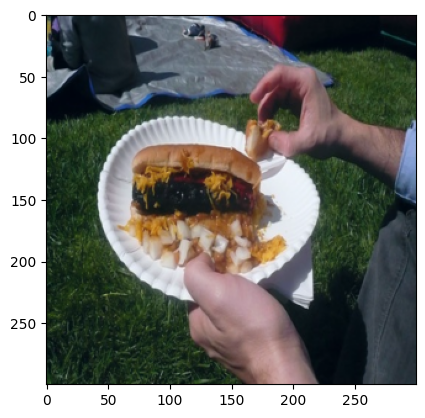

In [9]:
img = images[50] 
x = denormalize(img)
plt.imshow(x.permute(1,2,0))

# Options

1. training only the head with normal learning rate
2. training all with super low training rate

In [10]:
def transfer_model_set(model, freeze_convs=False,):
    
    if freeze_convs:
        print('Freezing Convs')
        # freeze the feature extractors
        for param in model.parameters():
            param.requires_grad = False
    
    if type(model) == torchvision.models.densenet.DenseNet:
        in_features = model.classifier.in_features
    
    elif type(model) == torchvision.models.resnet.ResNet:
        in_features = model.fc.in_features
    
    
    size_hidden = 512
    out_features = 1
    
    head = nn.Sequential(
                    nn.Linear(in_features, size_hidden),
                    nn.Dropout(DROP_OUT_RATE),
                    nn.ReLU(),
                    nn.BatchNorm1d(size_hidden),
                    nn.Linear(size_hidden, out_features),
                    nn.Sigmoid()        
    )
                    
    
    if type(model) == torchvision.models.densenet.DenseNet:
        model.classifier = head
    
    elif type(model) == torchvision.models.resnet.ResNet:
        model.fc = head

    else:
        raise Exception('Not implemented the classifier for this type of model')

    model = model.to(device)

    return model


# fixed parameters 
loss = nn.BCELoss() 

In [11]:
def set_optimizers():
    optimizers = {
        'ADAM':torch.optim.Adam,
        'SGD':torch.optim.SGD,
        'ADAMW':torch.optim.AdamW,
    }
    return optimizers 

# 1. Training just head

In [12]:
optimizers = set_optimizers()

In [ ]:

for optim, optimizer in optimizers.items():
        
    
    model = models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2) # lets take v2 here 
    model = transfer_model_set(model, freeze_convs=True)
    
    optimizer = optimizer(model.parameters(), HEAD_LEARNING_RATE)
    
    out_dict_resnet50 = train_transfer(model,
                                       train_loader, 
                                       test_loader,
                                       loss,
                                       optimizer,
                                       NUM_EPOCHS,
                                       save_model=True, 
                                       model_name='resnet50_head_' + optim)
    
    # saving results
    d = out_dict_resnet50
    with open(f'results/results_transfer_resnet_head_{NUM_EPOCHS}_epochs_{HEAD_LEARNING_RATE:.0e}_lr_{optim}_optim.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(d.keys())
        writer.writerows(zip(*d.values()))

Freezing Convs


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.242	 test: 0.163	 Accuracy train: 89.9%	 test: 93.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.135	 test: 0.134	 Accuracy train: 94.8%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.119	 test: 0.125	 Accuracy train: 95.8%	 test: 95.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.090	 test: 0.127	 Accuracy train: 96.4%	 test: 94.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.074	 test: 0.119	 Accuracy train: 97.4%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.078	 test: 0.132	 Accuracy train: 97.3%	 test: 94.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.064	 test: 0.132	 Accuracy train: 97.9%	 test: 95.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.064	 test: 0.132	 Accuracy train: 97.4%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.069	 test: 0.130	 Accuracy train: 97.4%	 test: 94.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.050	 test: 0.135	 Accuracy train: 98.0%	 test: 94.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.047	 test: 0.122	 Accuracy train: 98.2%	 test: 95.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.049	 test: 0.124	 Accuracy train: 98.4%	 test: 95.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.048	 test: 0.129	 Accuracy train: 98.1%	 test: 95.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.039	 test: 0.125	 Accuracy train: 98.6%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.038	 test: 0.127	 Accuracy train: 99.0%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.043	 test: 0.137	 Accuracy train: 98.5%	 test: 95.3%


  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
for optim, optimizer in optimizers.items():
    
    model = models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
    
    model = transfer_model_set(model, freeze_convs=True)
    
    optimizer = optimizer(model.parameters(), HEAD_LEARNING_RATE)
    
    out_dict = train_transfer(model, 
                              train_loader, 
                              test_loader,
                              loss,
                              optimizer,
                              NUM_EPOCHS,
                              save_model=True, 
                              model_name='densenet121_head_' + optim)
    
    # saving results
    d = out_dict
    with open(f'results/results_transfer_densenet_head_{NUM_EPOCHS}_epochs_{HEAD_LEARNING_RATE:.0e}_lr_{optim}_optim.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(d.keys())
        writer.writerows(zip(*d.values()))
    


# Train everything (but slowly! 🐢🐢🐢)

In [ ]:
for optim, optimizer in optimizers.items():
        
    model = models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2) # lets take v2 here 
    
    model = transfer_model_set(model, freeze_convs=False)
    
    optimizer = optimizer(model.parameters(), HEAD_LEARNING_RATE)
        
    out_dict_resnet50 = train_transfer(model,
                                       train_loader,
                                       test_loader,
                                       loss,
                                       optimizer,
                                       NUM_EPOCHS, 
                                       save_model=True, 
                                       model_name='resnet50_full_' + optim)
    
    # saving results
    d = out_dict_resnet50
    with open(f'results/results_transfer_resnet_full_{NUM_EPOCHS}_epochs_{FULL_LEARNING_RATE:.0e}_lr_{optim}_optim.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(d.keys())
        writer.writerows(zip(*d.values()))

In [ ]:
for optim, optimizer in optimizers.items():
    
    model = models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
    
    model = transfer_model_set(model, freeze_convs=False)
    
    optimizer = optimizer(model.parameters(), HEAD_LEARNING_RATE)
        
    out_dict = train_transfer(model,
                              train_loader,
                              test_loader,
                              loss,
                              optimizer,
                              NUM_EPOCHS, 
                              save_model=True, 
                              model_name='densenet121_full_' + optim)
    
    # saving results
    d = out_dict
    with open(f'results/results_transfer_densenet_full_{NUM_EPOCHS}_epochs_{FULL_LEARNING_RATE:.0e}_lr_{optim}_optim.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(d.keys())
        writer.writerows(zip(*d.values()))

# Saliency Maps 

In [ ]:
from matplotlib import pylab as P
import PIL.Image

In [ ]:
model = torch.load('models/resnet50_head_ADAMW')

In [ ]:
for test_images, test_labels in test_loader:  
    if test_labels.sum() > 1:
        sample_images = test_images    # Reshape them according to your needs.
        sample_labels = test_labels

In [ ]:
def denormalize(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    denormalize = transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                         std=[1/0.229, 1/0.224, 1/0.225])

    denorm_image = denormalize(img)
    x = ((denorm_image - denorm_image.min())/(denorm_image - denorm_image.min()).max() * 255).to(torch.int64)
    return x

In [ ]:
def calc_saliency(img, model):

    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    
    #input = transforms_0(img)
    input = img.unsqueeze(0)
    
    #we want to calculate gradient of higest score w.r.t. input
    
    #so set requires_grad to True for input 
    input.requires_grad = True
    
    #forward pass to calculate predictions
    preds = 1 - model(input.to(device))
    score, indices = torch.max(preds, 1)
    
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    return slc
    

In [ ]:
def smoothgrad(img, num_saliencies=20, eps=0.1):

    sum_saliencies = torch.tensor(np.zeros((300,300)))
    
    for _ in range(num_saliencies):
        
        img_with_noise = (img + torch.tensor(np.random.normal(0, eps * img.std(), img.shape))).to(torch.float)
        slc = calc_saliency(img_with_noise, model)
        sum_saliencies += slc

    saliency = sum_saliencies / num_saliencies

    return saliency

In [ ]:
def plot_saliency_and_img(img, sal):

    x = denormalize(img)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(x.permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(sal.numpy(), cmap=plt.cm.turbo)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
images, targets = next(iter(test_loader))

img = images[4] 
sal= smoothgrad(img, 20, 0.1)
# x = denormalize(img)

In [ ]:
plot_saliency_and_img(img, sal)

In [ ]:
model.eval()

input = img.unsqueeze(0)
input.requires_grad = True

model(input.to(device))

In [ ]:
img = sample_images[3] 
sal= smoothgrad(img, 20, 0.05)

plot_saliency_and_img(img, sal)

In [ ]:
model.eval()

input = img.unsqueeze(0)
input.requires_grad = True

model(input.to(device))

In [ ]:
test_img = PIL.Image.open('hot_dog_hamster.png')

In [ ]:
test_img.convert("RGB")
test_img = np.asarray(test_img, dtype=np.float32)/ 255
test_img = test_img[:, :, :3]

In [ ]:
test_img = torch.tensor(test_img).permute(2, 0, 1)

In [ ]:
img = test_img
sal= smoothgrad(img, 20, 0.05)

plot_saliency_and_img(img, sal)

In [ ]:
model.eval()

input = test_img.unsqueeze(0)
input.requires_grad = True

model(input.to(device))